In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
API_KEY = 'KOSRKMA8X6FK2B86'
ticker = 'AAL'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&interval=5min&apikey={API_KEY}'
file_to_save = f'{ticker}_data.csv'

In [ ]:
if not os.path.exists(file_to_save):
    with urllib.request.urlopen(url) as url:
        data = json.loads(url.read().decode())
        # extract stock market data
        data = data['Time Series (Daily)']
        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
        for k,v in data.items():
            date = dt.datetime.strptime(k, '%Y-%m-%d')
            data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                        float(v['4. close']),float(v['1. open'])]
            df.loc[-1,:] = data_row
            df.index = df.index + 1
    print('Data saved to : %s'%file_to_save)        
    df.to_csv(file_to_save, index=False)
else:
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(file_to_save)

File already exists. Loading data from CSV


In [ ]:
df = df.sort_values('Date')
print(df.head())

,Date,Low,High,Close,Open
99,2025-04-08,8.920,10.07,9.07,10.050
98,2025-04-09,9.085,11.23,11.12,9.130
97,2025-04-10,9.440,10.66,9.51,10.530
96,2025-04-11,9.300,9.70,9.67,9.510
95,2025-04-14,9.430,9.97,9.58,9.965


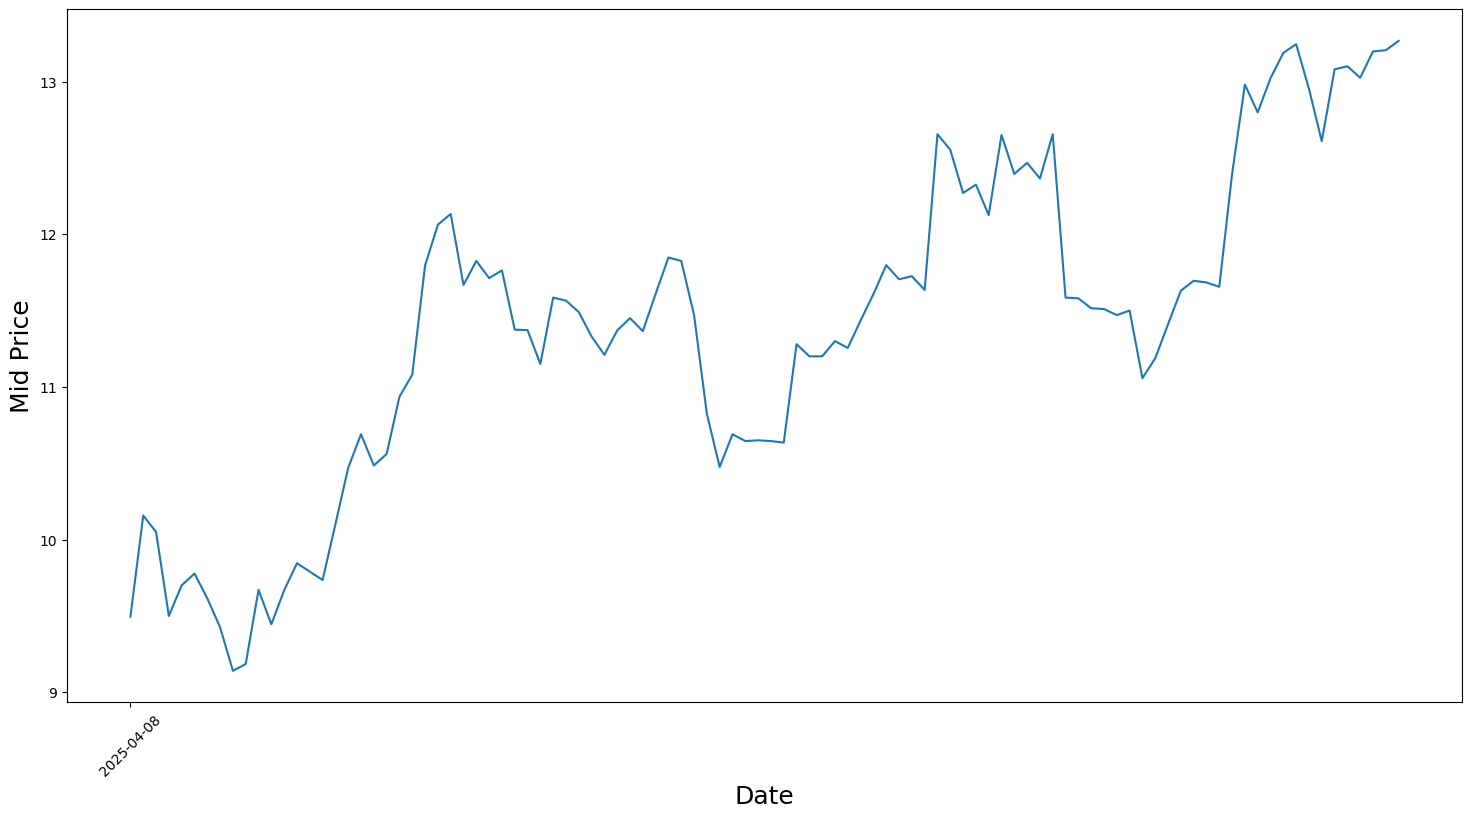

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

# Train/Test Split

In [ ]:
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices + low_prices) / 2.0

In [ ]:
split_idx = int(len(mid_prices) * 0.8)
train_data = mid_prices[:split_idx]
test_data = mid_prices[split_idx:]

# Normalizing the Data

In [ ]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [ ]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2500
for di in range(0, len(train_data), smoothing_window_size):
    end_idx = min(di + smoothing_window_size, len(train_data))
    if end_idx > di:  # Only process if there's actual data
        scaler.fit(train_data[di:end_idx,:])
        train_data[di:end_idx,:] = scaler.transform(train_data[di:end_idx,:])


# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)